# Python based Equity Backtester

## This script provides a basic Backtesting / Market Simulator infrastructure for a given equity trading strategy. 
 
Simply run the whole script to start the backtest# 
 
 - It runs over the previous 12 months from the current date. 

 - Each day and it corresponding event (buy / sell etc) will print to console.
 
 - A final plot of PnL will be displayed.


The idea is that you could 'plug-and-play' with various strategies -

currently a Z-score Mean Reversion strategy for "United Airlines" (or any other ticker symbol) based on significant 
deviation (1.5 Sigma) from the previous 20 day period mean.

It will buy or sell depending on the overbought / sold signal.  
____________________________________________________________________________________________________________________________




 - The first two classes create our variables to be used, and creates 
    a way of storing our equity data in a Dictionary - This is similar to 
    the 'Initialize' Method in the Zipline Package.
    
 - If there isn't an Equity ticker symbol in the Portfolio, then pull from Equity function. 


In [18]:
class Portfolio:
    def __init__(self):
        self.__store__ = dict()

    def add_end_p(self, time, symbol, price):
        EQdata = Equity(symbol, time, price)
        self.__store__[symbol] = EQdata

    def add_start_p(self, time, symbol, price):
        EQdata = self.PullEquity(symbol, time)
        EQdata.start_p = price


    def PullEquity(self, symbol, time):
        if not symbol in self.__store__:
            EQdata = Equity(symbol, time)
            self.__store__[symbol] = EQdata

        return self.__store__[symbol]

    def get_end_p(self, symbol):
        return self.__store__[symbol].end_p

    def get_start_p(self, symbol):
        return self.__store__[symbol].start_p

    def pull_timestamp(self, symbol):
        return self.__store__[symbol].timestamp


In [19]:
class Equity:
    def __init__(self, symbol, timestamp,
                 end_p=0):
        self.symbol = symbol
        self.timestamp = timestamp
        self.start_p = 0
        self.end_p = end_p


 - The StockPuller class, tells python what to do with the 
    DataFrame that we download from google finance. Here we are only
    interested in the Open and Close price.


In [20]:
#from pandas_datareader import data as web
import pandas.io.data as web

class StockPuller:
    def __init__(self):
        self.EQ_event, self.Tsymbol, self.source = None, None, None
        self.start, self.end = None, None
        self.mp = Portfolio()

    def PullData(self):
        data = web.DataReader(self.Tsymbol, self.source,
                              self.start, self.end)

        for time, row in data.iterrows():
            self.mp.add_end_p(time, self.Tsymbol,
                                   row["Close"])
            self.mp.add_start_p(time, self.Tsymbol, row["Open"])

            if not self.EQ_event is None:
                self.EQ_event(self.mp)


In [21]:
class Position:
    def __init__(self):
        self.symbol = None
        self.buys, self.sells, self.net = 0, 0, 0
        self.realized_pnl = 0
        self.unrealized_pnl = 0
        self.position_value = 0

    def bought(self, timestamp, is_buy, qty, price):
        if is_buy:
            self.buys += qty
        else:
            self.sells += qty

        self.net = self.buys - self.sells
        changed_value = qty * price * (-1 if is_buy else 1)
        self.position_value += changed_value

        if self.net == 0:
            self.realized_pnl = self.position_value

    def update_unrealized_pnl(self, price):
        if self.net == 0:
            self.unrealized_pnl = 0
        else:
            self.unrealized_pnl = price * self.net + \
                                  self.position_value

        return self.unrealized_pnl


In [22]:
class Signal:
    def __init__(self, timestamp, symbol, qty, is_buy,
                 is_market_order, price=0):
        self.timestamp = timestamp
        self.symbol = symbol
        self.qty = qty
        self.price = price
        self.is_buy = is_buy
        self.is_market_order = is_market_order
        self.is_filled = False
        self.filled_price = 0
        self.filled_time = None
        self.filled_qty = 0


 - This is a framework for all future strategies to run through, should we add new strategies. 


In [23]:
class Framework:
    def __init__(self):
        self.event_create = None

    def EQ_event(self, market_data):
        pass

    def event_order(self, order):
        pass

    def current_position(self, positions):
        pass

    def send_market_order(self, symbol, qty, is_buy, timestamp):
        if not self.event_create is None:
            order = Signal(timestamp, symbol, qty, is_buy, True)
            self.event_create(order)


 - This is the part that could be change out from it's current 'Mean Reversion' strategy to any other algo you choose (RSI, Moving Average, etc etc...)

In [24]:
class MeanReversion(Framework):
    def __init__(self, symbol,
                 periods=20,
                 buy_signal=-1.5,
                 sell_signal=1.5):
        Framework.__init__(self)
        self.symbol = symbol
        self.periods = periods
        self.buy_signal = buy_signal
        self.sell_signal = sell_signal
        self.prices = pd.DataFrame()
        self.is_long, self.is_short = False, False

    def current_position(self, positions):
        if self.symbol in positions:
            position = positions[self.symbol]
            self.is_long = True if position.net > 0 else False
            self.is_short = True if position.net < 0 else False

    def EQ_event(self, market_data):
        self.store_prices(market_data)

        if len(self.prices) < self.periods:
            return

        sigma_signal = self.sigma()
        timestamp = market_data.pull_timestamp(self.symbol)

        if sigma_signal < self.buy_signal:
            self.when_buy(timestamp)
        elif sigma_signal > self.sell_signal:
            self.when_sell(timestamp)

    def sigma(self):
        self.prices = self.prices[-self.periods:]
        returns = self.prices["close"].pct_change().dropna()
        z_score = ((returns-returns.mean())/returns.std())[-1]
        return z_score

    def when_buy(self, timestamp):
        if not self.is_long:
            self.send_market_order(self.symbol, 100,
                                   True, timestamp)

    def when_sell(self, timestamp):
        if not self.is_short:
            self.send_market_order(self.symbol, 100,
                                   False, timestamp)
    def store_prices(self, market_data):
        timestamp = market_data.pull_timestamp(self.symbol)
        self.prices.loc[timestamp, "close"] = \
            market_data.get_end_p(self.symbol)
        self.prices.loc[timestamp, "open"] = \
            market_data.get_start_p(self.symbol)


 - This is where the main functionality of the algo is found, (Similar to the 'Handle-Date'Method in Zipline). It handles the output to the console and manages all the data.

In [25]:
import datetime as dt
import pandas as pd

class MyBacktest:
    def __init__(self, symbol, start_date, end_date,
                 data_source="google"):
        self.target_symbol = symbol
        self.data_source = data_source
        self.start_dt = start_date
        self.end_dt = end_date
        self.strategy = None
        self.open_orders = []
        self.positions = dict()
        self.current_prices = None
        self.rpnl, self.upnl = pd.DataFrame(), pd.DataFrame()
        
    def portfolio_positions(self, symbol):
        if symbol not in self.positions:
            position = Position()
            position.symbol = symbol
            self.positions[symbol] = position

        return self.positions[symbol]

    def order_mgt(self, order):
        self.open_orders.append(order)

        print self.pull_date(), \
            "Order received to", \
            "BUY" if order.is_buy else "SELL", order.qty, \
             "units of", order.symbol        

    def pull_timestamp(self):
        return self.current_prices.pull_timestamp(
            self.target_symbol)

    def pull_date(self):
        timestamp = self.pull_timestamp()
        return timestamp.strftime("%Y-%m-%d")

    def changed_positions(self, symbol, qty, is_buy,
                               price, timestamp):
        position = self.portfolio_positions(symbol)
        position.bought(timestamp, is_buy, qty, price)
        self.strategy.current_position(self.positions)
        self.rpnl.loc[timestamp, "PnL"] = position.realized_pnl

        print self.pull_date(), \
            "You just", "BOUGHT" if is_buy else "SOLD", \
            qty, symbol, "at", price

    def sync_portfolio(self, prices):
        if len(self.open_orders) > 0:
            self.open_orders = \
                [order for order in self.open_orders
                 if self.unsynced(order, prices)]

    def unsynced(self, order, prices):
        symbol = order.symbol
        timestamp = prices.pull_timestamp(symbol)

        if order.is_market_order and timestamp > order.timestamp:

            order.is_filled = True
            start_p = prices.get_start_p(symbol)
            order.filled_timestamp = timestamp
            order.filled_price = start_p
            self.changed_positions(symbol,order.qty,
                                        order.is_buy, start_p, timestamp)
            self.strategy.event_order(order)
            return False

        return True

    def Output(self, symbol, prices):
        if symbol in self.positions:
            position = self.positions[symbol]
            close_price = prices.get_end_p(symbol)
            
            

            print self.pull_date(), \
                "Net Change:", position.net, \
                "Order Value:", position.position_value, \
                "PnL:", position.realized_pnl
                
    def Handle_data(self, prices):
        self.current_prices = prices
        self.strategy.EQ_event(prices)
        self.sync_portfolio(prices)
        self.Output(self.target_symbol, prices)

    
    def run_Backtest(self):
        self.strategy = MeanReversion(self.target_symbol)
        self.strategy.event_create = self.order_mgt

        mds = StockPuller()
        mds.EQ_event = self.Handle_data
        mds.Tsymbol = self.target_symbol
        mds.source = self.data_source
        mds.start, mds.end = self.start_dt, self.end_dt

        print "Starting Backtest..."
        mds.PullData()
        print "...Backtest Completed."




---- This bit of  code runs the above Backtesting Framework-----

 - It will print the daily values on the console as well as the time taken. It will then display a Plot showing the relative Profit & Loss of the strategy.


    This allows the backtest to be run at anytime and always be up to date
    on a trailing 12 month basis.  


Starting Backtest...
2015-03-27 Order received to SELL 100 units of UAL
2015-03-30 You just SOLD 100 UAL at 68.25
2015-03-30 Net Change: -100 Order Value: 6825.0 PnL: 0
2015-03-31 Net Change: -100 Order Value: 6825.0 PnL: 0
2015-04-01 Order received to BUY 100 units of UAL
2015-04-01 Net Change: -100 Order Value: 6825.0 PnL: 0
2015-04-02 You just BOUGHT 100 UAL at 64.24
2015-04-02 Net Change: 0 Order Value: 401.0 PnL: 401.0
2015-04-06 Net Change: 0 Order Value: 401.0 PnL: 401.0
2015-04-07 Net Change: 0 Order Value: 401.0 PnL: 401.0
2015-04-08 Net Change: 0 Order Value: 401.0 PnL: 401.0
2015-04-09 Net Change: 0 Order Value: 401.0 PnL: 401.0
2015-04-10 Net Change: 0 Order Value: 401.0 PnL: 401.0
2015-04-13 Net Change: 0 Order Value: 401.0 PnL: 401.0
2015-04-14 Net Change: 0 Order Value: 401.0 PnL: 401.0
2015-04-15 Net Change: 0 Order Value: 401.0 PnL: 401.0
2015-04-16 Net Change: 0 Order Value: 401.0 PnL: 401.0
2015-04-17 Net Change: 0 Order Value: 401.0 PnL: 401.0
2015-04-20 Net Change:

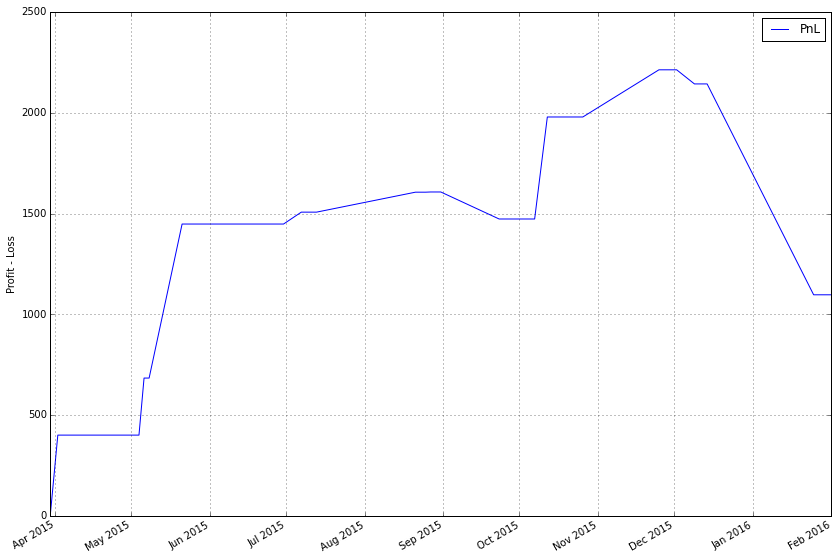

Duration: 0:00:22.417000


In [30]:
if __name__ == "__main__":
    from datetime import datetime
    start_time = datetime.now()

    runtest = MyBacktest("UAL",
                            dt.datetime.now() - dt.timedelta(weeks =52),
                            dt.datetime.now())
    runtest.run_Backtest()

    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.rcParams['figure.figsize'] = (14.0,10.0)
    runtest.rpnl.plot()
    plt.title('Net PnL - Trading 100 units of stock based on 1.5 stdev mean reversion'  )
    plt.ylabel('Profit - Loss $')
    plt.grid()
    plt.show()
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))    
    